# <center>CS-485 Data Science and Applications</center>
## <center>Assignment 5</center>
### <center>Alexandros Angelakis csdp1363, angelakis@csd.uoc.gr</center>

# Classify Fashing MNist images using CNNs



### **PART A: Training Convolutional Neural Networks (CNNs)**


In [2]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.v2 as v2
from torchsummary import summary
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

#### 1. Define the MNIST Dataset, Dataloader, Transforms. Use v2.Compose() to include even more transforms, such as rotations, crops and others.



In [2]:
# Define a Pytorch Transforms Pipeline
mean = [0.485]
std = [0.229]
transforms_train = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
])
transforms_test = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=mean, std=std),
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
])

# Load the MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transforms_train)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transforms_test)

batch_size = 128
# Create a DataLoader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Helper function that calculates the Accuracy of a given dataset/dataloader
def accuracy(loader, model):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            images, labels = data[0].to(device), data[1].to(device)
            ypred = F.softmax(model(images))
            ypred = np.argmax(ypred.cpu(), axis=1)
            total += labels.size(0)
            correct += (ypred == labels.cpu()).sum()
    model.train()
    return  correct / total

#### 3. Make your own version of CNN and report the validatation set accuracy



In [3]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.conv3 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        return x

# Create a model, loss function and optimizer
model = CNN().to(device)
summary(model, (1, 28, 28), device='cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 5
loss_history = []
valid_loss_history = []
val_step = 40

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_history.append(loss.item())

        # Print the loss every val_step
        if (i+1) % val_step == 0:
            with torch.no_grad():
                valid_running_loss = 0.0
                for j, vdata in enumerate(test_loader):
                    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                    voutputs = model(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    valid_running_loss += vloss.item()
            valid_loss_history.append(valid_running_loss / len(test_loader))
            print(f'Epoch [{epoch + 1}/{epochs}], Validation step {i+1}, Average Training Loss: {running_loss/val_step}, Average Validation Loss: {valid_running_loss / len(test_loader)}')
            running_loss = 0.0

print('Finished Training')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]          12,832
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]          51,264
         MaxPool2d-6             [-1, 64, 3, 3]               0
            Linear-7                   [-1, 10]           5,770
Total params: 70,282
Trainable params: 70,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.27
Estimated Total Size (MB): 0.48
----------------------------------------------------------------
Epoch [1/5], Validation step 40, Average Training Loss: 1.5299383670091629, Average Validation Loss: 0.91043

In [4]:
print("Validation accuracy is: ", accuracy(test_loader, model).item())

C:\Users\panat\AppData\Local\Temp\ipykernel_40756\3013723439.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.96670001745224


#### 4. Make 2 variations of CNNs (using different convolutions or pooling parameters) and compare them.



In [5]:
# Variation 1
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, padding='valid')
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 3, padding='valid')
        self.conv3 = nn.Conv2d(32, 64, 3, padding='valid')
        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Create a model, loss function and optimizer
model1 = CNN().to(device)
summary(model1, (1, 28, 28), device='cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model1.parameters(), lr=0.001)

epochs = 5
loss_history = []
valid_loss_history = []
val_step = 40

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model1(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_history.append(loss.item())

        # Print the loss every val_step
        if (i+1) % val_step == 0:
            with torch.no_grad():
                valid_running_loss = 0.0
                for j, vdata in enumerate(test_loader):
                    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                    voutputs = model1(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    valid_running_loss += vloss.item()
            valid_loss_history.append(valid_running_loss / len(test_loader))
            print(f'Epoch [{epoch + 1}/{epochs}], Validation step {i+1}, Average Training Loss: {running_loss/val_step}, Average Validation Loss: {valid_running_loss / len(test_loader)}')
            running_loss = 0.0

print('Finished Training')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
         MaxPool2d-2           [-1, 16, 13, 13]               0
            Conv2d-3           [-1, 32, 11, 11]           4,640
         MaxPool2d-4             [-1, 32, 5, 5]               0
            Conv2d-5             [-1, 64, 3, 3]          18,496
         MaxPool2d-6             [-1, 64, 1, 1]               0
            Linear-7                   [-1, 10]             650
Total params: 23,946
Trainable params: 23,946
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.14
Params size (MB): 0.09
Estimated Total Size (MB): 0.24
----------------------------------------------------------------
Epoch [1/5], Validation step 40, Average Training Loss: 1.9781606137752532, Average Validation Loss: 1.45951

In [6]:
print("Validation accuracy is: ", accuracy(test_loader, model1).item())

C:\Users\panat\AppData\Local\Temp\ipykernel_40756\3013723439.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.9309999942779541


In [7]:
# Variation 2
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 7, padding='same')
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(16, 32, 7, padding='same')
        self.conv3 = nn.Conv2d(32, 64, 7, padding='same')
        self.fc1 = nn.Linear(64 * 3 * 3, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Create a model, loss function and optimizer
model2 = CNN().to(device)
summary(model2, (1, 28, 28), device='cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)

epochs = 5
loss_history = []
valid_loss_history = []
val_step = 40

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_history.append(loss.item())

        # Print the loss every val_step
        if (i+1) % val_step == 0:
            with torch.no_grad():
                valid_running_loss = 0.0
                for j, vdata in enumerate(test_loader):
                    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                    voutputs = model2(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    valid_running_loss += vloss.item()
            valid_loss_history.append(valid_running_loss / len(test_loader))
            print(f'Epoch [{epoch + 1}/{epochs}], Validation step {i+1}, Average Training Loss: {running_loss/val_step}, Average Validation Loss: {valid_running_loss / len(test_loader)}')
            running_loss = 0.0

print('Finished Training')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             800
         MaxPool2d-2           [-1, 16, 14, 14]               0
            Conv2d-3           [-1, 32, 14, 14]          25,120
         MaxPool2d-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 7, 7]         100,416
         MaxPool2d-6             [-1, 64, 3, 3]               0
            Linear-7                   [-1, 10]           5,770
Total params: 132,106
Trainable params: 132,106
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.50
Estimated Total Size (MB): 0.71
----------------------------------------------------------------
Epoch [1/5], Validation step 40, Average Training Loss: 1.5259677216410636, Average Validation Loss: 0.956

In [8]:
print("Validation accuracy is: ", accuracy(test_loader, model2).item())

C:\Users\panat\AppData\Local\Temp\ipykernel_40756\3013723439.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.9686999917030334


#### 5. Increase the number of Layers of the CNN (the number of convolutions followed by pooling layers) and observe what happens, in terms of the progress of the training and validation losses and the final model accuracies.



In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.LeakyReLU(0.2)
        self.dropout = nn.Dropout(0.4)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=(2,2), padding=2)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=(2,2), padding=2)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=(3,3), stride=(2,2), padding=2)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=(3,3), stride=(2,2), padding=2)
        self.conv5 = nn.Conv2d(128, 128, kernel_size=(3,3), stride=(2,2), padding=2)
        self.fc1 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.dropout(self.pool(self.relu(self.conv1(x))))
        x = self.dropout(self.pool(self.relu(self.conv2(x))))
        x = self.dropout(self.pool(self.relu(self.conv3(x))))
        x = self.dropout(self.pool(self.relu(self.conv4(x))))
        x = self.dropout(self.pool(self.relu(self.conv5(x))))
        # print(x.shape)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

# Create a model, loss function and optimizer
model3 = CNN().to(device)
summary(model3, (1, 28, 28), device='cuda')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)

epochs = 5
loss_history = []
valid_loss_history = []
val_step = 40

# Train the model
for epoch in range(epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()
        outputs = model3(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        loss_history.append(loss.item())

        # Print the loss every val_step
        if (i+1) % val_step == 0:
            with torch.no_grad():
                valid_running_loss = 0.0
                for j, vdata in enumerate(test_loader):
                    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                    voutputs = model3(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    valid_running_loss += vloss.item()
            valid_loss_history.append(valid_running_loss / len(test_loader))
            print(f'Epoch [{epoch + 1}/{epochs}], Validation step {i+1}, Average Training Loss: {running_loss/val_step}, Average Validation Loss: {valid_running_loss / len(test_loader)}')
            running_loss = 0.0

print('Finished Training')


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 15, 15]             320
         LeakyReLU-2           [-1, 32, 15, 15]               0
         MaxPool2d-3             [-1, 32, 7, 7]               0
           Dropout-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 32, 5, 5]           9,248
         LeakyReLU-6             [-1, 32, 5, 5]               0
         MaxPool2d-7             [-1, 32, 2, 2]               0
           Dropout-8             [-1, 32, 2, 2]               0
            Conv2d-9             [-1, 64, 2, 2]          18,496
        LeakyReLU-10             [-1, 64, 2, 2]               0
        MaxPool2d-11             [-1, 64, 1, 1]               0
          Dropout-12             [-1, 64, 1, 1]               0
           Conv2d-13            [-1, 128, 2, 2]          73,856
        LeakyReLU-14            [-1, 12

We can see that when we are increasing the number of layers (and thus the number of parameters), it is more difficult to our model to learn. The Average Validation loss and Training loss is decreasing but in a very slow pace. Maybe if we increase the epochs, change the learning rate and batch size, it will have a better progress of training. The accuracy is also significantly lower, from 96.86% we went down to 81.1%.

In [10]:
print("Validation accuracy is: ", accuracy(test_loader, model3).item())

C:\Users\panat\AppData\Local\Temp\ipykernel_40756\3013723439.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.8116000294685364


#### 6. Visualize some of the Feature Maps and Convolution Kernels that you find interesting.

We'll take the best of our model in order to visualize some of the feature maps and convolution kernels.

torch.Size([1, 28, 28])
torch.Size([16, 28, 28])
torch.Size([32, 14, 14])
torch.Size([64, 7, 7])


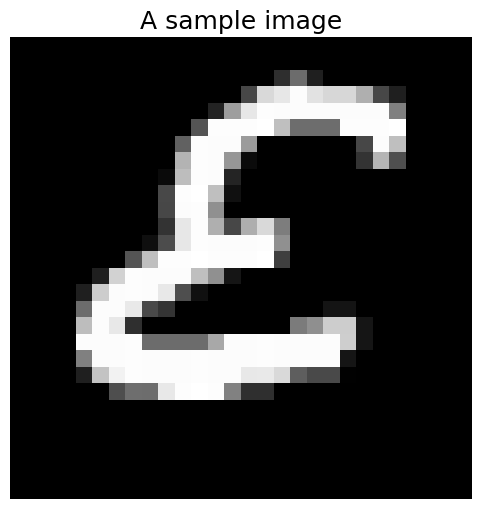

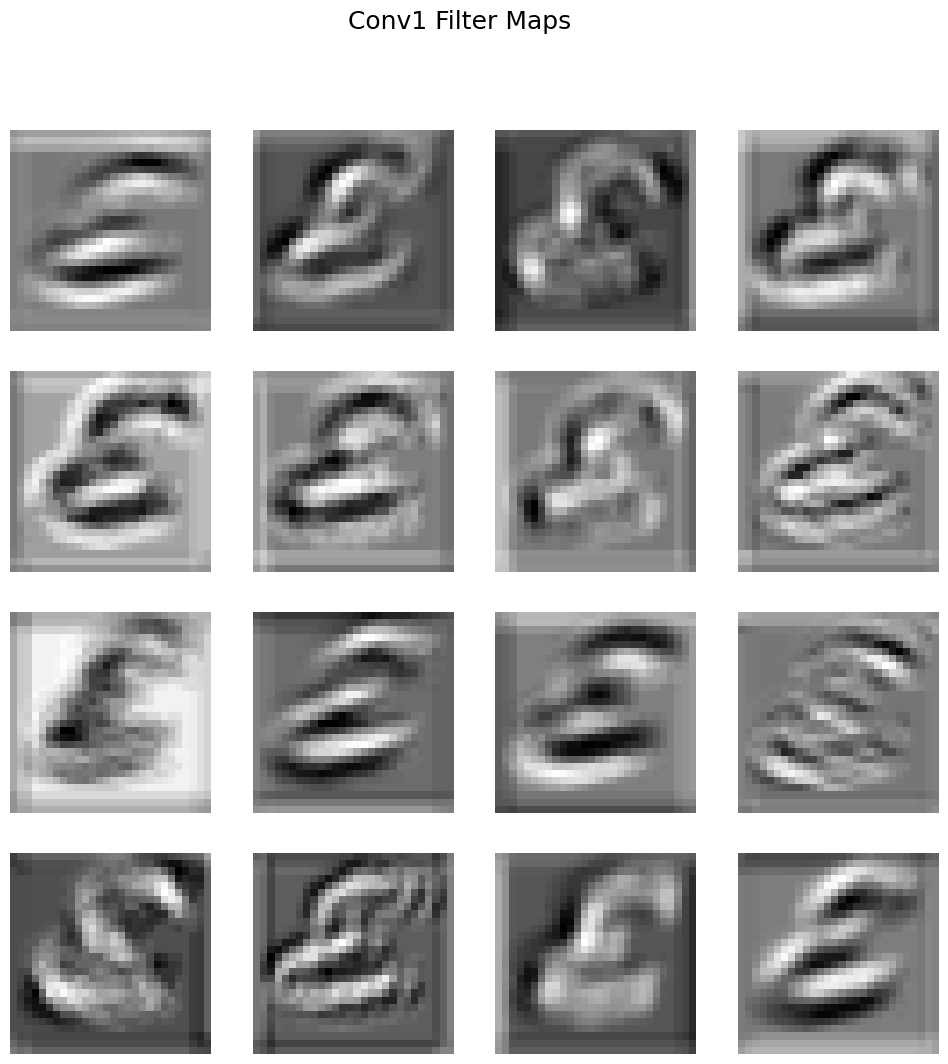

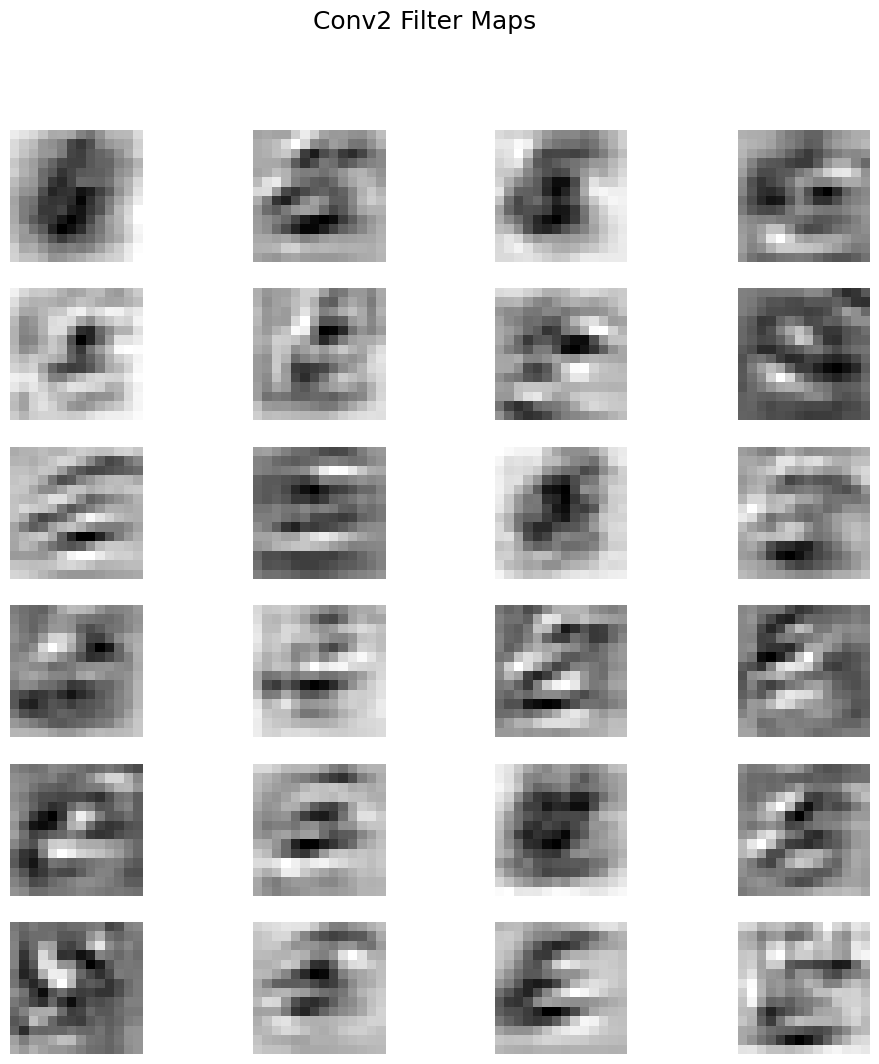

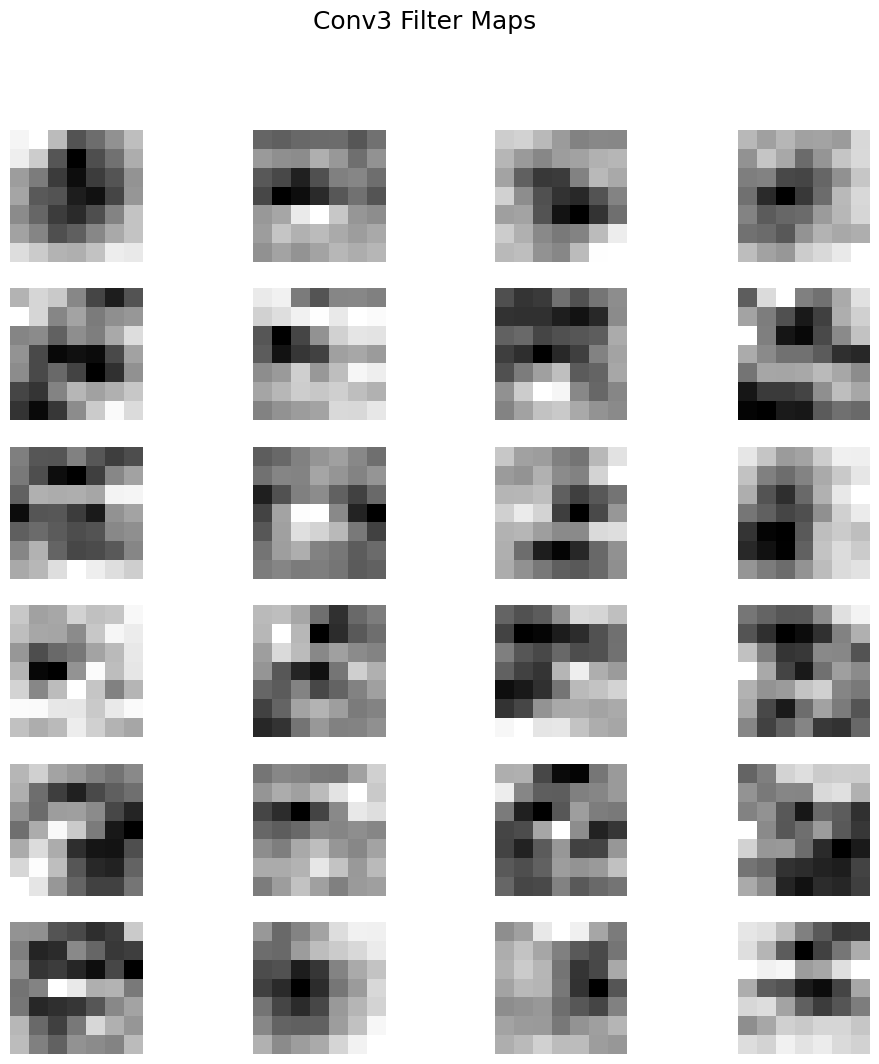

In [19]:
# Let's visualize the feature maps
# Acquire an image
images = next(iter(train_loader))
image = images[0][0]
print(image.shape)

fig, axs = plt.subplots(1, 1, figsize=(6, 6))
axs.imshow(image.numpy()[0, :, :], cmap="gray")
axs.axis("off")
axs.set_title("A sample image", fontsize=18)

with torch.no_grad():
    image = image.to(device)
    feat_map1 = model2.conv1(image)
    print(feat_map1.shape)
    feat_map1 = feat_map1.cpu().detach().numpy()
    fig, axs = plt.subplots(4, 4, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < feat_map1.shape[1]:  # Check if the channel index is less than the number of channels
            # Index the batch dimension (0) and the channel dimension (i)
            ax.imshow(feat_map1[i, :, :], cmap="gray")
            ax.axis('off')  # Hide the axis
        else:
            ax.axis('off')  # Hide the axis for unused subplots

    fig.suptitle("Conv1 Filter Maps", fontsize=18)

    feat_map2 = model2.conv1(image)
    feat_map2 = F.relu(feat_map2)
    feat_map2 = model2.pool(feat_map2)
    feat_map2 = model2.conv2(feat_map2)
    print(feat_map2.shape)
    feat_map2 = feat_map2.cpu().detach().numpy()
    fig, axs = plt.subplots(6, 4, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < feat_map2.shape[0]:  # Check if the channel index is less than the number of channels
            # Index the batch dimension (0) and the channel dimension (i)
            ax.imshow(feat_map2[i, :, :], cmap="gray")
            ax.axis('off')  # Hide the axis
        else:
            ax.axis('off')  # Hide the axis for unused subplots

    fig.suptitle("Conv2 Filter Maps", fontsize=18)

    feat_map3 = model2.conv1(image)
    feat_map3 = F.relu(feat_map3)
    feat_map3 = model2.pool(feat_map3)
    feat_map3 = model2.conv2(feat_map3)
    feat_map3 = F.relu(feat_map3)
    feat_map3 = model2.pool(feat_map3)
    feat_map3 = model2.conv3(feat_map3)

    print(feat_map3.shape)
    feat_map3 = feat_map3.cpu().detach().numpy()
    fig, axs = plt.subplots(6, 4, figsize=(12, 12))
    for i, ax in enumerate(axs.flat):
        if i < feat_map3.shape[0]:  # Check if the channel index is less than the number of channels
            # Index the batch dimension (0) and the channel dimension (i)
            ax.imshow(feat_map3[i, :, :], cmap="gray")
            ax.axis('off')  # Hide the axis
        else:
            ax.axis('off')  # Hide the axis for unused subplots

    fig.suptitle("Conv3 Filter Maps", fontsize=18)

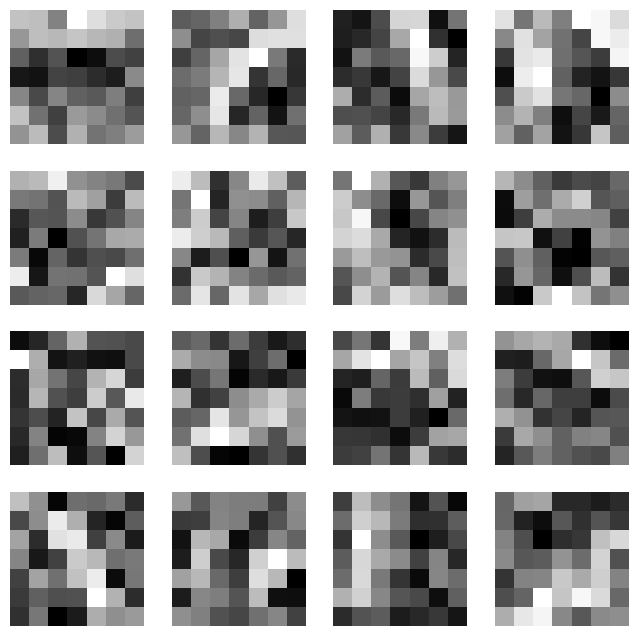

In [22]:
# Let's visualize the kernels
kernels = model2.conv1.weight.detach()

# Move kernels to CPU if they are on GPU
kernels = kernels.cpu()

# Normalize kernels to [0,1] for visualization
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

# Assuming you're dealing with a single input channel (e.g., grayscale images),
# you might want to visualize each output channel's kernel separately.
num_kernels = kernels.size(0)

# Set up the subplot dimensions
cols = int(np.sqrt(num_kernels))
rows = (num_kernels // cols) + (0 if num_kernels % cols == 0 else 1)

fig, axs = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

for i, ax in enumerate(axs.flat):
    if i < num_kernels:
        # Select the i-th kernel, note that kernels[i].shape == [in_channels, H, W],
        # for grayscale (single channel inputs), it will be [1, H, W].
        # We squeeze it to [H, W] for visualization.
        kernel = kernels[i].squeeze()
        # For single-channel inputs, you can index as [0] to get the 2D kernel if in_channels > 1.
        # If your model works with multi-channel images (e.g., RGB), you'll need a strategy
        # to visualize these 3D kernels, such as showing each input channel's kernel separately.

        ax.imshow(kernel, cmap='gray')
        ax.axis('off')
    else:
        ax.axis('off')

plt.show()

### **PART B: Transfer Learning**







#### 1. Load a Pretrained model (the simpler the better for computational efficiency e.g.resnet16). You are gonna use it to train your model on Fashion Mnist

In [17]:
# Transfer Learning
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.FashionMNIST(root='./data1', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.FashionMNIST(root='./data1', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

model = torchvision.models.resnet50(pretrained=True)

#### 2. Freeze the BackBone of the pretrained model (Convolutions etc) and modify the final fully connected layer/layers that perform classification (make sure the new output dimension matches the number of classes in Fashion Mnist)

In [18]:
# Freeze model parameters (for feature extraction only, remove for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(classes))  # Adapt to Fashion-MNIST

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### 3. Train the model on Fashion Mnist for a few epoches and log your train/val loss progress as well as the final model accuracy on the validation set.

In [19]:
criterion = nn.CrossEntropyLoss()

# Optimize only the fully connected layer (for fine-tuning, include all parameters)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

loss_history = []
valid_loss_history = []
val_step = 40
epochs = 5

for epoch in range(epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        loss_history.append(loss.item())

        # Print the loss every val_step
        if (i+1) % val_step == 0:
            with torch.no_grad():
                valid_running_loss = 0.0
                for j, vdata in enumerate(testloader):
                    vinputs, vlabels = vdata[0].to(device), vdata[1].to(device)

                    voutputs = model(vinputs)
                    vloss = criterion(voutputs, vlabels)
                    valid_running_loss += vloss.item()
            valid_loss_history.append(valid_running_loss / len(testloader))
            print(f'Epoch [{epoch + 1}/{epochs}], Validation step {i+1}, Average Training Loss: {running_loss/val_step}, Average Validation Loss: {valid_running_loss / len(testloader)}')
            running_loss = 0.0

print('Finished Training')

Epoch [1/5], Validation step 40, Average Training Loss: 1.6037777543067933, Average Validation Loss: 1.1050646599335006
Epoch [1/5], Validation step 80, Average Training Loss: 0.9322030782699585, Average Validation Loss: 0.8485100231593168
Epoch [1/5], Validation step 120, Average Training Loss: 0.7775676488876343, Average Validation Loss: 0.7290875647641435
Epoch [1/5], Validation step 160, Average Training Loss: 0.7230477303266525, Average Validation Loss: 0.6733246445655823
Epoch [1/5], Validation step 200, Average Training Loss: 0.6795339286327362, Average Validation Loss: 0.652508860147452
Epoch [1/5], Validation step 240, Average Training Loss: 0.6357042819261551, Average Validation Loss: 0.631762549092498
Epoch [1/5], Validation step 280, Average Training Loss: 0.6195723280310631, Average Validation Loss: 0.6057195655907257
Epoch [1/5], Validation step 320, Average Training Loss: 0.5873936682939529, Average Validation Loss: 0.5839377558684047
Epoch [1/5], Validation step 360, Av

In [21]:
# Helper function that calculates the Accuracy of a given dataset/dataloader
def accuracy(loader, model):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for i, data in enumerate(loader):
            images, labels = data[0].to(device), data[1].to(device)
            ypred = F.softmax(model(images))
            ypred = np.argmax(ypred.cpu(), axis=1)
            total += labels.size(0)
            correct += (ypred == labels.cpu()).sum()
    model.train()
    return  correct / total

print("Validation accuracy is: ", accuracy(testloader, model).item())

C:\Users\panat\AppData\Local\Temp\ipykernel_44388\685517815.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ypred = F.softmax(model(images))


Validation accuracy is:  0.8497999906539917
